Updates:

16th January 2021: Shifted my notebooks onto GitHub for easier integration, in particular to track changes.

References: 

[Reference 1](https://stackoverflow.com/questions/59454990/how-to-push-from-colab-to-github)

[Reference 2](https://lalorosas.com/blog/github-colab-drive)

[Reference 3](https://sam-thurman.medium.com/integrating-google-drive-colab-with-github-bffaca97eb5b)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/My Drive/Cassava/zip-folder/Cassava-JPEG-128x128.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/kaggle/train_images_jpeg/3952546193.jpg  
  inflating: /content/kaggle/train_images_jpeg/3952799769.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953140534.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953222407.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953247024.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953327881.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953331047.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953514366.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953530273.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953560426.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953648207.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953857113.jpg  
  inflating: /content/kaggle/train_images_jpeg/3953901317.jpg  
  inflating: /content/kaggle/train_images_jpeg/3954180556.jpg  
  inflating: /content/kaggle/train_images_jpeg/395423

In [ ]:
!pip install -q torchsummary
!pip install -q torch==1.7.0
!pip install -q torchvision==0.8.1
!pip install -q scikit-learn==0.23.2
!pip install -q albumentations==0.5.1

!pip install -q geffnet==1.0.0
!pip install -q torchtoolbox==0.1.5

     |████████████████████████████████| 6.8MB 14.0MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 952kB 16.7MB/s 
     |████████████████████████████████| 37.6MB 147kB/s 
     |████████████████████████████████| 61kB 6.6MB/s 


In [ ]:
import os
import random
import time
from typing import *
import PIL.Image
import albumentations
import cv2
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.optim import *
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import models
from tqdm import tqdm


import geffnet
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Config

In [ ]:
class GlobalConfig:
    seed = 1930
    num_classes = 11
    class_list = [0,1,2,3,4,5,6,7,8,9,10]
    batch_size = 16
    n_epochs = 15
    tensor_size = (8,3,64,64)
   
    # unpack the key dict
    scheduler = 'CosineAnnealingWarmRestarts'
    scheduler_params = {'StepLR': {'step_size':2, 'gamma':0.3, 'last_epoch':-1, 'verbose':True},
                
                'ReduceLROnPlateau': {'mode':'max', 'factor':0.5, 'patience':0, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-5,
                                      'eps':1e-08, 'verbose':True},
                
                'CosineAnnealingWarmRestarts': {'T_0':10, 'T_mult':1, 'eta_min':1e-6, 'last_epoch':-1,
                                                'verbose':True}}
    
    # do scheduler.step after optimizer.step
    train_step_scheduler = False  
    val_step_scheduler = True
    
    # optimizer
    optimizer = 'AdamW'
    optimizer_params = {'AdamW':{'lr':1e-3, 'betas':(0.9,0.999), 'eps':1e-08,
                                 'weight_decay':1e-6,'amsgrad':False}, 
                        'Adam':{'lr':1e-4,'betas':(0.9,0.999), 'eps':1e-08,
                                 'weight_decay':1e-6,'amsgrad':False},}

    # criterion
    criterion = 'BCEWithLogitsLoss'
    criterion_val = 'BCEWithLogitsLoss'
    criterion_params = {'BCEWithLogitsLoss': {'weight':None,'size_average':None,
                                             'reduce':None, 'reduction':'mean', 'pos_weight': None},
                        'CrossEntropyLoss': {'weight':None,'size_average':None,
                                             'ignore_index':-100,'reduce':None,
                                             'reduction':'mean'},
                        'LabelSmoothingLoss': {'classes':2, 'smoothing':0.05, 'dim':-1},
                        'FocalCosineLoss': {'alpha':1, 'gamma':2 , 'xent':0.1}}



    image_col_name = 'image_id'
    class_col_name = 'label'
    paths = {'train_path': '/content/kaggle/train_images_jpeg/',
             'test_path': '../input/siim-isic-melanoma-classification/jpeg/test',
             'csv_path': '/content/drive/My Drive/Cassava/input/cassava-leaf-disease-classification/train.csv',
             'log_path': './log.text',
             'save_path': '/content/drive/My Drive/Cassava/weights/tf_effnet_b4_ns/18-Jan-V1',
             'model_weight_path_folder': '/content/drive/My Drive/pretrained-effnet-weights',
             'image_path' : '/content/drive/My Drive/deep-learning-notes/notebooks/images'}

    model_name = 'tf_efficientnet_b5_ns'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
config = GlobalConfig

# Utils

In [ ]:
def seed_all(seed: int = 1930):

    print("I love my Grandpa so the seed number is {}".format(seed))

    os.environ["PYTHONHASHSEED"] = str(
        seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    random.seed(
        seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


def seed_worker(_worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

######################################################################
seed_all(config.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
######################################################################

I love my Grandpa so the seed number is 1930


In [ ]:
def make_rand_tensors(config):
    # Create a batch size of 8 random images with 3 channels and 64x64 -> [N,C,W,H]
    rand_tensor = torch.ones(config.tensor_size, dtype=torch.float).to(config.device)
    return rand_tensor

def torchsummary_wrapper(model, image_size: Tuple):
    
    model_summary = summary(model, image_size)
    return model_summary

In [ ]:
def display_image(config, page_num):
    image = os.path.join(config.paths['hongnan_notes'], page_num)
    return Image(image)

# Learning the Syntax of PyTorch

`torch.view()` [reference](https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch)



### torch.nn vs torch.nn.functional

[torch.nn.Relu vs torch.nn.functional.Relu](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599/3)

[using-dropout-in-pytorch-nn-dropout-vs-f-dropout](https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout)

# Building Neural Networks

## Convolutional Layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
!unzip '/content/drive/My Drive/deep-learning-notes/notebooks/hymenoptera_data.zip' -d '/content/'

Archive:  /content/drive/My Drive/deep-learning-notes/notebooks/hymenoptera_data.zip
   creating: /content/hymenoptera_data/
   creating: /content/hymenoptera_data/train/
   creating: /content/hymenoptera_data/train/ants/
  inflating: /content/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: /

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

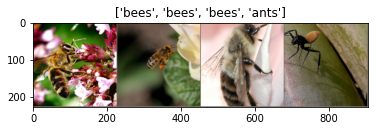

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.4348 Acc: 0.7951
val Loss: 0.1981 Acc: 0.9085

Training complete in 0m 3s
Best val Acc: 0.908497


## Hooks - The amazing trick you should know

[the-one-pytorch-trick-which-you-should-know](https://towardsdatascience.com/the-one-pytorch-trick-which-you-should-know-2d5e9c1da2ca)

In [ ]:
import torch
from torchvision.models import resnet34


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = resnet34(pretrained=True)
model = model.to(device)

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
save_output = SaveOutput()

hook_handles = []

for layer in model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [ ]:

image = PIL.Image.open(os.path.join(config.paths['image_path'], 'cat.jpg'))
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
X = transform(image).unsqueeze(dim=0).to(device)

out = model(X)

In [ ]:
len(save_output.outputs)

36

In [ ]:
save_output.outputs

[tensor([[[[-8.4063e-02, -3.1156e-01, -3.7922e-01,  ..., -3.1241e-01,
            -3.1991e-01, -7.8703e-02],
           [-6.6684e-01, -1.0324e+00, -1.1204e+00,  ..., -1.5653e+00,
            -1.5471e+00, -6.4014e-01],
           [-3.4449e-01, -6.4493e-01, -7.2495e-01,  ..., -1.2277e+00,
            -1.2087e+00, -4.5994e-01],
           ...,
           [ 2.1659e-02, -4.6106e-02, -2.1702e-01,  ..., -1.0963e-01,
            -1.2138e-01, -1.5617e-01],
           [-3.2920e-02, -1.3041e-01, -3.1823e-01,  ..., -2.6584e-02,
            -3.2380e-02, -1.1487e-01],
           [ 4.4561e-01, -2.9023e-01, -1.0615e+00,  ...,  4.9755e-01,
             4.4903e-01,  2.2949e-01]],
 
          [[-4.6110e-02, -3.0740e-02, -1.0826e-01,  ..., -7.0238e-02,
            -9.2460e-02, -2.0240e+00],
           [-3.5144e-02, -1.7679e-02, -4.9731e-02,  ..., -1.2231e-02,
            -9.3168e-03, -2.8310e+00],
           [-7.0530e-02, -3.8022e-02, -4.4606e-02,  ..., -4.5727e-03,
             2.5627e-02, -2.7854e+00],


# Transfer Learning

## Input Shape's importance in Transfer Learning


[1. torchvision.models.vgg.py](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py)

[2. changing-input-dimension-for-alexnet](https://stackoverflow.com/questions/55810665/changing-input-dimension-for-alexnet)

[3. is-it-possible-to-give-variable-sized-images-as-input-to-a-convolutional-neural](https://stats.stackexchange.com/questions/388859/is-it-possible-to-give-variable-sized-images-as-input-to-a-convolutional-neural)

### VGG16

We use an extremely simple tranfer learning model from `torchvision.models` and use this as a vanilla example to understand our problem statement. One should understand one of the fundamental reason why we use transfer learning is because the model is already pre-trained on millions of images; this is often the case as we usually benchmark our performance on model that are trained on `imagenet`. However, problem arises as we try to transfer our learned weights and layers from the said model, to our own custom dataset. Why? We will unveil the mystery soon, but first keep in mind two important concepts:

1. Convolutional Layers are independent of the input size/shape.

2. Dense or Fully Connected Layers are dependent on the input size/shape.

3. Conclusion: As long as the pretrained model has Dense/FC layers, then how do we reconcile the fact that our input shape may be different from the ones that were trained on?


Below: I present the source code of `vgg16` and we will use it later.

In [ ]:
import torch
import torch.nn as nn
# from .utils import load_state_dict_from_url
from typing import Union, List, Dict, Any, cast

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'MaxPool', 128, 'MaxPool', 256, 256, 'MaxPool', 512, 512, 'MaxPool', 512, 512, 'MaxPool'],
    'B': [64, 64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 'MaxPool', 512, 512, 'MaxPool', 512, 512, 'MaxPool'],
    'D': [64, 64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 'MaxPool', 512, 512, 512, 'MaxPool', 512, 512, 512, 'MaxPool'],
    'E': [64, 64, 'MaxPool', 128, 128, 'MaxPool', 256, 256, 256, 256, 'MaxPool', 512, 512, 512, 512, 'MaxPool', 512, 512, 512, 512, 'MaxPool'],
}
    
    
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> torch.nn.Sequential:
    layers: List[torch.nn.Module] = []
    in_channels = 3
    for feature_map_type in cfg:
        if feature_map_type == 'MaxPool':
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            feature_map_type = cast(int, feature_map_type)
            conv2d = torch.nn.Conv2d(in_channels=in_channels, out_channels=feature_map_type, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, torch.nn.BatchNorm2d(feature_map_type), torch.nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, torch.nn.ReLU(inplace=True)]
            in_channels = feature_map_type
    return torch.nn.Sequential(*layers)


class VGG(torch.nn.Module):

    def __init__(
        self,
        features: torch.nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        
        # Feature Maps, where the layers here are mostly Conv2d, serving as a feature extractor.
        self.features = features
        # AdaptiveAvgPool2d ensures that whatever your input image size is, it will come out the same output before it cotorch.nnects to the dense layer.
        self.avgpool = torch.nn.AdaptiveAvgPool2d((7, 7))
        # Classifier Layers, usually the densely fully cotorch.nnected layers whereby your prediction is being made.
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512 * 7 * 7, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, input_neurons: torch.Tensor) -> torch.Tensor:
        feature_map_output_neurons = self.features(input_neurons)
        adaptive_pool_output_neurons = self.avgpool(feature_map_output_neurons)
        print('Before Flattening Shape {}'.format(adaptive_pool_output_neurons.size()))
        # flatten vs view, I think around the same.
        flattened_neurons = adaptive_pool_output_neurons.view(adaptive_pool_output_neurons.size(0), -1)
        #flattened_neurons = torch.flatten(adaptive_pool_output_neurons, 1)
        print('After Flattening Shape {}'.format(flattened_neurons.size()))
        output_logits = self.classifier(flattened_neurons)
        return output_logits

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
                
                
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg16(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

1. These are the last few fully connected layers of VGG16, `Sequential` in this manner means that, we have the first linear layer where the tensor inputs called $x$ will go through a linear transformation $z=w^T \cdot x+b$, then apply an `activation` function $a=\text{ReLU}(z)$ such as `ReLU` , and lastly apply a dropout to make the tensor $a$ to have 0s randomly - for every value $t \in a$, with a probability $p$, set $t=0$. 

        nn.Sequential(
                    nn.Linear(512 * 7 * 7, 4096),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(4096, 4096),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(4096, num_classes),
                )

In [ ]:
# NOT RECOMMENDED, using the source code's method is better.
class VGG16(torch.nn.Module):
    def __init__(self, init_weights=True):
        super(VGG16, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv7 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv8 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv9 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv10 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv11 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv12 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv13 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        # Sequential Linear (fully-connected) Layers with affine operations y=Wx+b
        self.fc1 = torch.nn.Linear(in_features=25088,out_features=4096, bias=True)
        self.fc2 = torch.nn.Linear(in_features=4096,out_features=4096, bias=True)
        # last layer before softmax - usually called include_top in Keras.
        self.fc3 = torch.nn.Linear(in_features=4096,out_features=1000, bias=True)
        # completed 16 layers, hence the name VGG16
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        self.activation = torch.nn.ReLU(inplace=True)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((7, 7))
        
        if init_weights:
            self._initialize_weights()
        
    def forward(self, input_neurons: torch.Tensor)-> torch.Tensor:
        input_neurons = self.activation(self.conv1(input_neurons))
        input_neurons = self.activation(self.conv2(input_neurons))
        # note here we are using maxpooling with stride 2 on conv2 layer before we proceed to conv3
        input_neurons = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(self.conv2(input_neurons))
        input_neurons = self.activation(self.conv3(input_neurons))
        input_neurons = self.activation(self.conv4(input_neurons))
        input_neurons = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(self.conv4(input_neurons))
        input_neurons = self.activation(self.conv5(input_neurons))
        input_neurons = self.activation(self.conv6(input_neurons))
        input_neurons = self.activation(self.conv7(input_neurons))
        input_neurons = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(self.conv7(input_neurons))
        input_neurons = self.activation(self.conv8(input_neurons))
        input_neurons = self.activation(self.conv9(input_neurons))
        input_neurons = self.activation(self.conv10(input_neurons))
        input_neurons = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(self.conv10(input_neurons))
        input_neurons = self.activation(self.conv11(input_neurons))
        input_neurons = self.activation(self.conv12(input_neurons))
        input_neurons = self.activation(self.conv13(input_neurons))
        input_neurons = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(self.conv13(input_neurons))
        # Adaptive Layer
        input_neurons = self.avgpool(input_neurons)
        # Flatten
        input_neurons = torch.flatten(input_neurons,1)
        # or
        # input_neurons = torch.view(input_neurons, -1)
        # Fully Connected Layers Below
        input_neurons = self.dropout(self.activation(self.fc1(input_neurons)))
        input_neurons = self.dropout(self.activation(self.fc2(input_neurons)))
        input_neurons = self.fc3(input_neurons)
        return input_neurons
        
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
        
    

### nn.AdaptiveAvgPool2d

**Reference 2:**

As stated in https://github.com/pytorch/vision/releases:

> Since, most of the pretrained models provided in `torchvision` (the newest version) already added `self.avgpool = nn.AdaptiveAvgPool2d((size, size))` to resolve the incompatibility with input size. So you don't have to care about it so much.

Below is the code, very short.

```python
import torchvision
import torch.nn as nn

num_classes = 8
model = torchvision.models.alexnet(pretrained=True)
# replace the last classifier
model.classifier[6] = nn.Linear(4096, num_classes)

# now you can trained it with your dataset of size (3, 448, 224)
```

### Two ways of Transfer learning

There are two popular ways to do transfer learning. Suppose that we trained a model `M` in very large dataset `D_large`, now we would like to transfer the "knowledge" learned by the model `M` to our new model, `M'`, on other datasets such as `D_other` (which has a smaller size than that of `D_large`).

1. Use (most) parts of `M` as the architecture of our new `M'` and initialize those parts with the weights trained on `D_large`. We can start training the model `M'` on the dataset `D_other` and let it learn the weights of those above parts from `M` to find the optimal weights on our new dataset. This is usually referred as fine-tuning the model `M'`. 

2. Same as the above method except that before training `M'` we freeze all the parameters of those parts and start training `M'` on our dataset `D_other`. In both cases, those parts from `M` are mostly the first components in the model `M'` (the base). However, in this case, we refer those parts of `M` as the model to extract the features from the input dataset (or feature extractor). The accuracy obtained from the two methods may differ a little to some extent. However, this method guarantees the model doesn't overfit on the small dataset. It's a good point in terms of accuracy. On the other hands, when we freeze the weights of `M`, we don't need to store some intermediate values (the hidden outputs from each hidden layer) in the forward pass and also don't need to compute the `gradients` during the backward pass. This improves the speed of training and reduces the memory required during training. 

### The implementation

Along with `Alexnet`, a lot of pretrained models on ImageNet is already provided by Facebook team such as ResNet, VGG. 

To fit your requirements the most in the aspect of model size, it would be nice to use VGG11, and ResNet which have fewest parameters in their model family.
 
I just pick VGG11 as an example:

1. Obtain a pretrained model from `torchvision`.
2. Freeze the all the parameters of this model.
3. Replace the last layer in the model by your new `Linear` layer to perform your classification. This means that you can reuse all most everything of `M` to `M'`. 

```python
import torchvision

# obtain the pretrained model
model = torchvision.models.vgg11(pretrained=True)

# freeze the params
for param in net.parameters():
    param.requires_grad = False

# replace with your classifier
num_classes = 8
net.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# start training with your dataset
```

### Warnings
In the old `torchvision` package version, there is no `self.avgpool = nn.AdaptiveAvgPool2d((size, size))` which makes harder to train on our input size which is different from `[3, 224, 224]` used in training ImageNet. You can do a little effort as below:

```python


class OurVGG11(nn.Module):

    def __init__(self, num_classes=8):
        super(OurVGG11, self).__init__()
        self.vgg11 = torchvision.models.vgg11(pretrained=True)
        for param in self.vgg11.parameters():
            param.requires_grad = False
        
        # Add a avgpool here
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Replace the classifier layer
        self.vgg11.classifier[-1] = nn.Linear(4096, num_classes)


    def forward(self, x):
        x = self.vgg11.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 512 * 7 * 7)
        x = self.vgg11.classifier(x)
        return x

model = OurVGG11()

# now start training `model` on our dataset.
```
Try out with different models in `torchvision.models`.

**Reference 3:**

The convolutional layers and pooling layers themselves are independent of the input dimensions. However, the output of the convolutional layers will have different spatial sizes for differently sized images, and this will cause an issue if we have a fully connected layer afterwards (since our fully connected layer requires a fixed size input). There are several solutions to this:

**1. Global Pooling:** Avoid fully connected layers at the end of the convolutional layers, and instead use pooling (such as Global Average Pooling) to reduce your feature maps from a shape of (N,H,W,C) (before global pool) to shape (N,1,1,C) (after global pool), where:<br><br>
N = Number of minibatch samples<br>
H = Spatial height of feature map<br>
W = Spatial width of feature map<br>
C = Number of feature maps (channels)<br><br>
As can be seen, the output dimensionality (N*C) is now independent of the spatial size (H,W) of the feature maps. In case of classification, you can then proceed to use a fully connected layer on top to get the logits for your classes.<br><br>

**2. Variable sized pooling:** Use variable sized pooling regions to get the same feature map size for different input sizes.
<br><br>

**3. Crop/Resize/Pad input images:** You can try to rescale/crop/pad your input images to all have the same shape.
<br><br>
<hr>
In the context of transfer learning, you might want to use differently sized inputs than the original inputs that the model was trained with. Here are some options for doing so:<br><br>

**4. Create new fully connected layers:** You can ditch the original fully connected layers completely and initialize a new fully connected layer with the dimensionality that you need, and train it from scratch.<br><br>

**5. Treat the fully connected layer as a  convolution:** Normally, we reshape the feature maps from (N,H,W,C) to (N,H\*W\*C) before feeding it to the fully connected layer. But you can also treat the fully connected layer as a convolution with a receptive field of (H,W). Then, you can just convolve this kernel with your feature maps regardless of their size (use zero padding if needed) [http://cs231n.github.io/transfer-learning/ ].

**Reference Hongnan (My own interpretation):**

The convolutional and pooling layers in a CNN network are independent of the image size (input shape), this is because the weights of each convolutional layers are calculated only on the number of filters (out_channels). Please refer to my image in Deep Learning Notes on how to calculate number of parameters (which is the number of weights). It is as simple as 

$$f^{\ell} \times f^{\ell} \times n_{c}^{\ell-1} \times n_{c}^{\ell} + n_{b}^{\ell}$$

where we denote 

$f^{\ell} = \text{filter size in current layer}$

$n_{c}^{\ell-1} = \text{number of filters/channels in previous layer}$

$n_{c}^{\ell} = \text{number of filters in current layer}$

$n_{b}^{\ell} = \text{number of bias in current layer}$

So one can simply calculate the first layer's paramaters/weights as follows:

$$\text{number of weights/paramaters} = 3\times 3 \times 3 \times 64 + 64 = 1792$$

and for the second layer it is:

$$\text{number of weights/paramaters} = 3\times 3 \times 64 \times 64 + 64 = 36928$$

What I did just now is to make a point that when we calculate the weights/paramaters of each CNN layer, there is absolutely no input shape or image size involved. Thus, the implication is that the number of weights of a CNN layer is **invariant of the input shape**. However, the output shape of each CNN layer is not the same for varying image size, and this will pose a problem - which will be explained in the next part. Before we go, take a moment to run the code below and see that for 2 different input shape 224 vs 512 and you see the only changes are the output shape, the number of weights and parameters are not changed.

In [ ]:
vgg16_hn = vgg16(pretrained=True,progress=True).to(config.device)
twotwofour = torchsummary_wrapper(vgg16_hn, (3,224,224))
fiveonetwo = torchsummary_wrapper(vgg16_hn, (3, 512, 512))

The output of the convolutional layers will have different spatial sizes for differently sized images, and this will cause an issue if we have a fully connected layer afterwards (since our fully connected layer requires a fixed size input). So for example **VGG16** which is pretrained on `imagenet` with image sizes of 224x224, then when you load the `state dict`, the number of weights and parameters are already fixed. To be more verbose, the number of weights for the convolutional layers stay the same for any input image size, but the fully connected layers will not. For example, in the native resolution of 224x224, the layer before the fully connected layer is a convolutional layer and subsequent pooling layer - which has an output shape of `(-1, 512, 7, 7)`. We need to flatten this pooling layer into a dense layer first, one can imagine in a 3-dimensional perpective that we squashed a pool of 3-dimensional neurons into a vertical fully connected neurons. Refer to this image: 

Now, some intuition needs to be provided here, for the absent minded (me), look further after the image pasted above for the math behind weights (pages after). 

Continuing above, we know that the learnable weights of the flattened layer is $512\times 7\times 7 = 25088$, and since we are connected to a pre-defined fully connected layer of 4096 neurons, then it follows that in this very fully connected layer, we will output $$25088\times 4096 + 4096 = 102764544$$ weights. This is a fixed number and will change if you change the image input size.

For example, if I were to input a 512x512 image, see the code above, then the previous layer before the fully connected layer is actually `[-1, 512, 16, 16]` which is not the same as $512\times 7 \times 7$. This will lead to our weights mismatched at the fully connected layer. So we can solve this problem by using `nn.AdaptiveAvgPooling`.

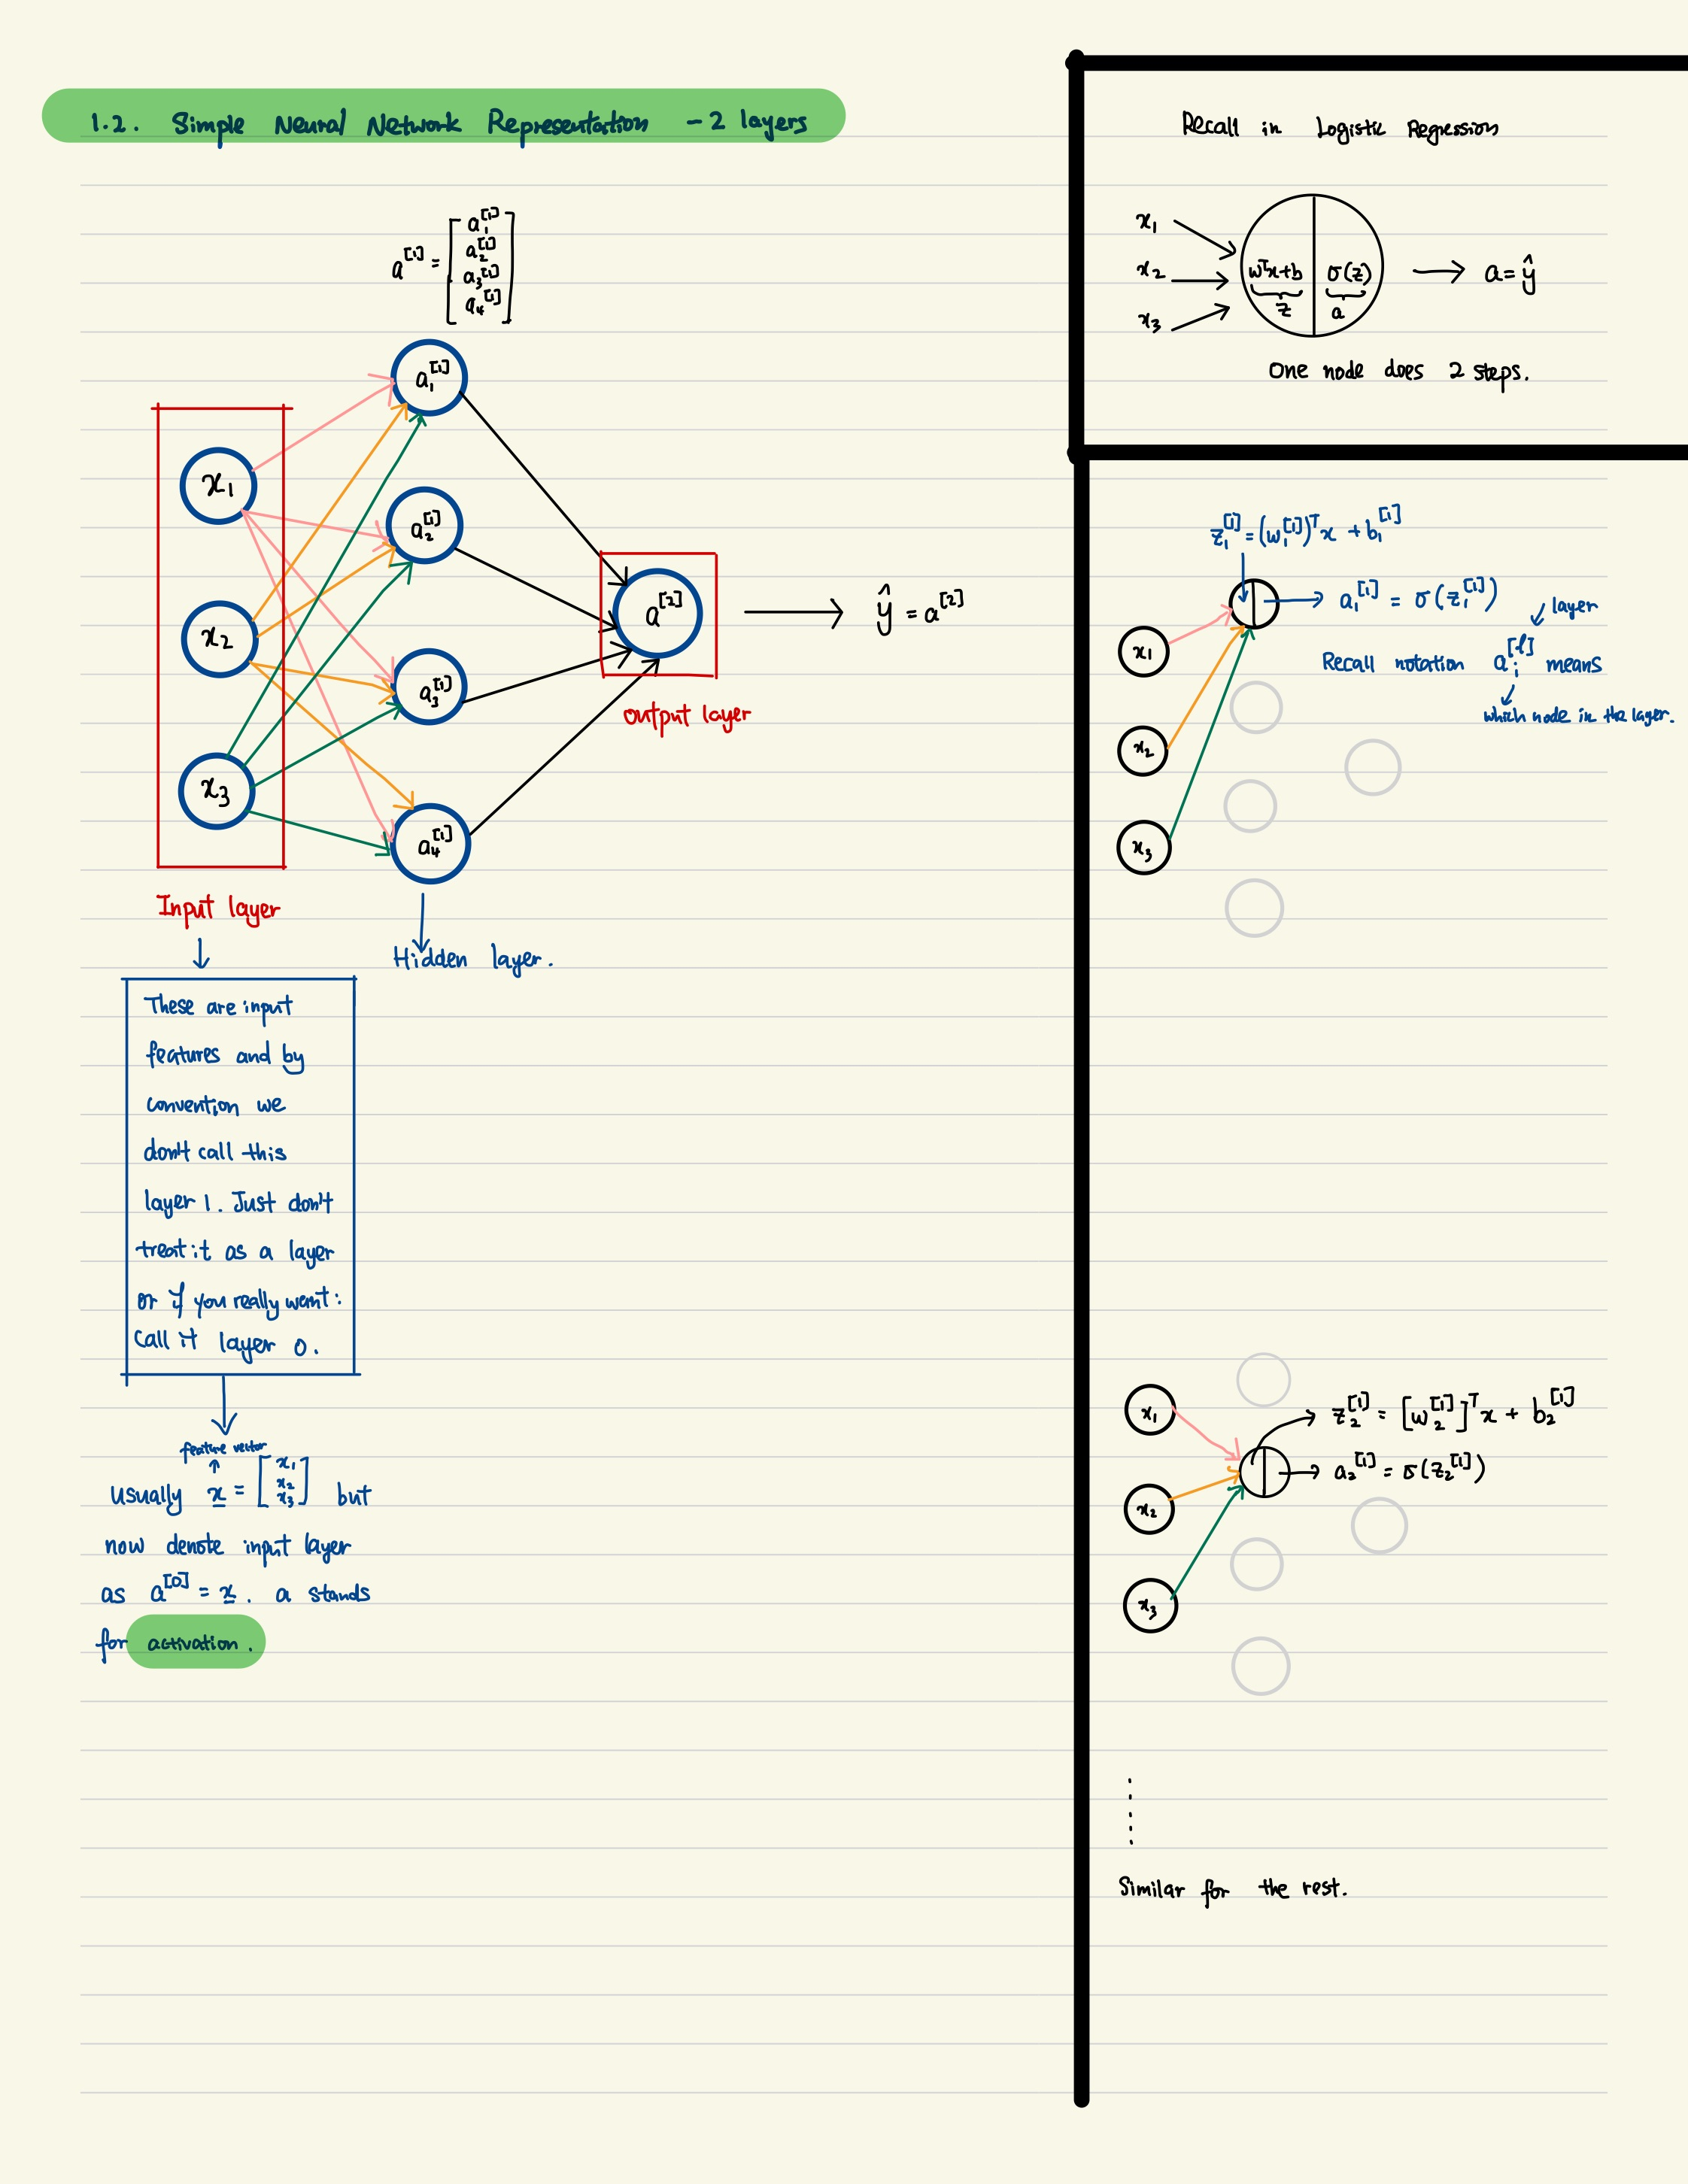

In [ ]:
display_image(config, page_num = 'Deep learning-17.jpg')

Side note: by fixing the `seed`, you will get deterministic results for every re-run of the model. For example, if I want to compare two implementations of `vgg16`, namely, `vgg16v1` and `vgg16v2` and see if they give deterministic outputs, then one should notrun `vgg16v1(rand_tensor)` and `vgg16v2(rand_tensor)` at the same time even though you would expect they yield the same results - since we are forward passing the `rand_tensor` across a fixed set of pretrained weights. But calling it twice in one run will indicate it's called twice, so to check if they really output the same tensor (deterministic), you need to run them on 2 separate runs.

# High Level Code Overview on Image Classification

# Tips and Tricks to speed up Training in PyTorch

[1. Absolutely amazing article on speeding up training in PyTorch plus good practices](https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide/)

The wholesome article below is entirely based on this amazing article, and all credits should go to him. I did, however, repackaged it and included more details.

## The choice of Learning Rate Scheduler Matters!

[Hyper-parameter Tuning Techniques in Deep Learning](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8)

[PyTorch LR Finder](https://github.com/davidtvs/pytorch-lr-finder)



The learning rate of the an optimizer has a large impact on the speed of convergence as well as the generalization performance of your model. This is why in almost all the cases, a learning rate scheduler is used in training as well.

**Cyclical Learning Rate** and the **One Cycle Learning Rate** schedulers are both methods introduced by Leslie N. Smith ([here](https://arxiv.org/pdf/1506.01186.pdf) and [here](https://arxiv.org/abs/1708.07120)), and then popularised by fast.ai's Jeremy Howard and Sylvain Gugger ([here](https://www.fast.ai/2018/07/02/adam-weight-decay/) and [here](https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb)). Essentially, the **One Cycle Learning Rate** scheduler looks something like this:

![image info](https://github.com/ghnreigns/Deep-Learning-Notes/blob/main/pictures/one_cycle_lr.png?raw=1)

Sylvain writes:

> [Onecycle consists of]  two steps of equal lengths, one going from a
> lower learning rate to a higher one than go back to the minimum. The
> maximum should be the value picked with the Learning Rate Finder, and
> the lower one can be ten times lower. Then, the length of this cycle
> should be slightly less than the total number of epochs, and, in the
> last part of training, we should allow the learning rate to decrease
> more than the minimum, by several orders of magnitude.


In the best case this schedule achieves a massive speed-up – what Smith calls Superconvergence – as compared to conventional learning rate schedules. Using the 1Cycle policy he needs ~10x fewer training iterations of a ResNet-56 on ImageNet to match the performance of the original paper, for instance). The schedule seems to perform robustly well across common architectures and optimizers.


PyTorch implements both of these methods `torch.optim.lr_scheduler.CyclicLR` and `torch.optim.lr_scheduler.OneCycleLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html).

One drawback of these schedulers is that they introduce a number of additional hyperparameters. [hyper-parameter-tuning-techniques-in-deep-learning](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8) and [PyTorch learning rate finder](https://github.com/davidtvs/pytorch-lr-finder), offer a nice overview and implementation of how good hyper-parameters can be found including the Learning Rate Finder mentioned above. In conclusion, this is related to hyper-parameter tuning and should not be neglected.

Why does this work? It doesn't seem entirely clear but one [possible explanation](https://arxiv.org/pdf/1506.01186.pdf) might be that regularly increasing the learning rate helps to traverse [saddle points in the loss landscape](https://papers.nips.cc/paper/2015/file/430c3626b879b4005d41b8a46172e0c0-Paper.pdf) more quickly.


## DataLoader Tricks

When using `torch.utils.data.DataLoader`, set `num_workers > 0, rather than the default value of 0, and `pin_memory=True`, rather than the default value of `False`. Details of this are explained in [documentation](https://pytorch.org/docs/stable/data.html).

[Szymon Micacz](https://nvlabs.github.io/eccv2020-mixed-precision-tutorial/files/szymon_migacz-pytorch-performance-tuning-guide.pdf) achieves a 2x speed-up for a single training epoch by using four workers and pinned memory.

A [rule of thumb](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5) that people are using to choose the number of workers is to set it to four times the number of available GPUs with both a larger and smaller number of workers leading to a slow down.

Note that increasing num_workers will increase your CPU memory consumption.

## Batch Size

This is a somewhat contentious point. Generally, however, it seems like using the largest batch size your GPU memory permits will accelerate your training (see [NVIDIA's Szymon Migacz](https://nvlabs.github.io/eccv2020-mixed-precision-tutorial/files/szymon_migacz-pytorch-performance-tuning-guide.pdf), for instance). Note that you will also have to adjust other hyperparameters, such as the learning rate, if you modify the batch size. A rule of thumb here is to double the learning rate as you double the batch size.

[OpenAI has a nice empirical paper](https://arxiv.org/pdf/1812.06162.pdf) on the number of convergence steps needed for different batch sizes. [Daniel Huynh](https://towardsdatascience.com/implementing-a-batch-size-finder-in-fastai-how-to-get-a-4x-speedup-with-better-generalization-813d686f6bdf) runs some experiments with different batch sizes (also using the 1Cycle policy discussed above) where he achieves a 4x speed-up by going from batch size 64 to 512.

One of the [downsides](https://arxiv.org/pdf/1609.04836.pdf) of using large batch sizes, however, is that they might lead to solutions that generalize worse than those trained with smaller batches.

## Use Automatic Mixed Precision (AMP)

[PyTorch Documentation Examples](https://pytorch.org/docs/stable/notes/amp_examples.html)

The release of PyTorch 1.6 included a native implementation of Automatic Mixed Precision training to PyTorch. The main idea here is that certain operations can be run faster and without a loss of accuracy at semi-precision (FP16) rather than in the single-precision (FP32) used elsewhere. AMP, then, automatically decide which operation should be executed in which format. This allows both for faster training and a smaller memory footprint.

To be very honest with you, many people use AMP wrongly, so I am very confused at who to follow, so usually I try to follow documentation, or people on Kaggle.

# Dissecting the train_one_epoch code

PyTorch **1.7**

## model.train() and model.eval()

- `model.train()` and `model.eval()`

   `model.train()` tells your model that you are training the model. So effectively layers like `dropout`, `batchnorm` etc, which behave differently on the train and test procedures know what is going on and hence can behave accordingly. More details: It sets the mode to train (see [source code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.train)). You can call either `model.eval()` or `model.train(mode=False)` to tell that you are testing/evaluating. It is somewhat intuitive to expect train function to train model but it does not do that. It just sets the mode. In case of `model.train()` the model knows it has to learn the layers and when we use `model.eval()` it indicates the model that nothing new is to be learnt and the model is used for testing. 

   [Reference 1](https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch) 
    
   [Reference 2](https://medium.com/jun-devpblog/pytorch-6-model-train-vs-model-eval-no-grad-hyperparameter-tuning-3812c216a3bd)

## to(device)

- `to(device)`

   First you have to set `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` to define your device, whether you are equipping your tensors/model on GPU/CPU. Subsequently, you can use the `tensor.to(device)` command to move a tensor to a device (either GPU or CPU). 

        for step, (images, labels, img_ids) in enumerate(sample_loader):
            # print('Before to device, image tensor is\n', images)
            # print('Before to device, labels tensor is\n', labels)
            images = images.to(device)
            labels = labels.to(device)
        
   When you `print(images)`, the output tensors will end with `cuda:0` to signify you have moved your tensors to GPU. 
   
   Common Error: RuntimeError: `Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same`. You get this error because your `model` is on the GPU, but your `data/images/label tensors` are on the CPU. So, you need to send your input tensors to the GPU. Alternatively, The same error will be raised if your input tensors are on the GPU but your model weights aren't. In this case, you need to send your model weights to the GPU. So remember to do `model.cuda()` or `model.to(device)` as well when you train. In general, both tensors and model should have `tensor.to(device)` and `model.to(device)` so that both are synchronized, since `device` will be a constant variable.

    [Reference I on to(device)](https://stackoverflow.com/questions/50954479/using-cuda-with-pytorch)
    
    [Reference II on RunTimeError](https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte)

## batch_size

`batch_size = images.shape[0]` vs `batch_size = images.shape[0]`

Do not use `batch_size = config.batch_size`, this is because if you do not set `drop_last=True` in the `DataLoader`, then we will encounter a problem, if the total number of images is 30, and we set our `batch_size = 4`, then we will run into a problem when we iterate our data into the last iteration - we have only 2 images left, and if we still assume that our `batch_size` is 4, then our `Accuracy Score/Meter` will be affected, because those are dependent on the `batch_size`.

## y_pred=model(images)

### Definition of logits

- `y_pred = model(images)`

   `y_pred` is the value of the logits of a `forward` pass in the neural network. One would think the last layer in a classification problem would either be the `sigmoid` or `softmax` layer, however, `y_pred = model(images)` does not seem to sum up to 1, which is against the definition of `softmax`. The reason is because when you call `model(images)`, you are basically invoking `model.forward(images)` in the `model` class you instantiated, and this by default gives you logits, not softmax values.
   
   With reference to [this](https://discuss.pytorch.org/t/two-output-nodes-for-binary-classification/58703): 
    
   For a binary classification use case, you could use a single output and a threshold or alternatively you could use a multi-class classification with just two classes, so that each class gets its output neuron. The loss functions for both approaches would be different. In the first case (single output), you would use e.g. `nn.BCEWithLogitsLoss` and the output tensor shape should match the target shape. In the latter case, you would use e.g. `nn.CrossEntropyLoss` and the target tensor shape should contain the class indices in the range `[0, num_classes-1]` and miss the “class dimension” (usually the channel dim). **Both approaches expect logits, so you should remove your `softmax` layer and just pass the last output to the criterion.** A final linear layer is not strictly necessary, if you make sure to work with the right shapes of your output and target.
    
   So as we can see, the last `linear` layer of a PyTorch forward pass outputs **logits**, and subsequently, **logits** are expected to be passed in to the `loss` function.
    
   Also, one reason that I kept forgetting what `logits` really are is because of my own incompetency, after revising through my notes, I have a better picture now. Referring to the attached images, one should recall there are two steps in each neuron, there should be a $z = w^Tx+b$ function where $w$ are the weights and $x$, the inputs; further note that the number of weights is equals to the number of neurons in the previous layer; the second step is the activation function $a = g(z)$ where $g$ is the activation function. So in our scenario, when I get to the last layer, I necessarily thought that the last layer will be a layer with 5 output neurons (we have 5 classes), and each neuron's output should be $a = g(z)$ where $g$ is the softmax activation function in question. Apparently, I am wrong. In PyTorch, the last layer is only half the story, it stripped off the softmax "portion" and only presents us with the raw **logits**, or in other words, $z = w^Tx+b$; in other words, the raw output of a neural network layer is **the linear combination** of the values that come from the neurons of the previous layer. An mental example is: if the layer before the last `linear layer` (last layer) has 20 neurons/output values, and my `linear layer` has 5 outputs/classes, I can expect the output of the `linear layer` to be an array with 5 values, each of which is the linear combination of the 20 values multiplied by the 20 weights + bias, corresponding to $z = w^Tx+b$, but in vectorized form. These, are called **logits**, the unnormalized final scores of your model, without going through the `sotfmax` function.
    
    ![neural network](https://github.com/ghnreigns/Deep-Learning-Notes/blob/main/images/neural_network_1.jpg?raw=1)

   A last note before we proceed is that the input of `nn.CrossEntropyLoss` mathematically, should be the prediction (the output of model) in probability (not **logits**) and the label. `nn.CrossEntropyLoss` function in PyTorch will compute the probability of prediction of model automatically. From the [source code](https://pytorch.org/docs/master/_modules/torch/nn/functional.html#cross_entropy), this is confirmed to be true.

   [what-does-logits-in-machine-learning-mean](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean)

   [two-output-nodes-for-binary-classification](https://discuss.pytorch.org/t/two-output-nodes-for-binary-classification/58703/3)
           
   [neural_networks_tutorial](http://seba1511.net/tutorials/beginner/blitz/neural_networks_tutorial.html)

   [what-does-the-forward-function-output-in-pytorch](https://stackoverflow.com/questions/64987430/what-exactly-does-the-forward-function-output-in-pytorch?noredirect=1#comment114909082_64987430)   

   Here is an extract of [what-does-logits-in-machine-learning-mean](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean):
    
   **Logits interpreted to be the unnormalised** (or not-yet normalised) **predictions** (or outputs) **of a model. These can give results, but we don't normally stop with logits, because interpreting their raw values is not easy.**

   Have a look at [their definition][1] to help understand how *logits* are produced.

### Example of logits

   Let me explain with an example:

   We want to train a model that learns how to classify cats and dogs, using photos that each contain either one cat or one dog. You build a model give it some of the data you have to approximate a mapping between images and predictions. You then give the model some of the unseen photos in order to test its predictive accuracy on new data. As we have a classification problem (we are trying to put each photo into one of two classes), the model will give us two scores for each input image. A score for how likely it believes the image contains a cat, and then a score for its belief that the image contains a dog.

   Perhaps for the first new image, you get logit values out of `16.917` for a cat and then `0.772` for a dog. Higher means better, or ('more likely'), so you'd say that a cat is the answer. The correct answer is a cat, so the model worked!

   For the second image, the model may say the logit values are 1.004 for a cat and 0.709 for a dog. So once again, our model says we the image contains a cat. The correct answer is once again a cat, so the model worked again!

   Now we want to compare the two result. One way to do this is to normalise the scores. That is, **we normalise the logits**! Doing this we gain some insight into the confidence of our model.

   Let's using [the softmax][2], where all results sum to `1` and so allow us to think of them as probabilities:

   $$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}} \text{ for } j = 1, …, K.$$

   For the first test image, we get

   $$prob(cat) = \frac{exp(16.917)}{exp(16.917) + exp(0.772)} = 0.9999$$

   $$prob(dog) = \frac{exp(0.772)}{exp(16.917) + exp(0.772)} = 0.0001$$

   If we do the same for the second image, we get the results:

   $$prob(cat) = \frac{exp(1.004)}{exp(1.004) + exp(0.709)} = 0.5732$$

   $$prob(dog) = \frac{exp(0.709)}{exp(1.004) + exp(0.709)} = 0.4268$$

   The model was not really sure about the second image, as it was very close to 50-50 - a guess!

   The last part of the quote from your question likely refers to a neural network as the model. The layers of a neural network commonly take input data, multiply that by some parameters (weights) that we want to learn, then apply a **non-linearity** function, which provides the model with the power to learn non-linear relationships. Without this non-linearity, a neural network would simply be a list of linear operations, performed on some input data, which means it would only be able to learn linear relationships. This would be a massive constraint, meaning the model could always be reduced to a basic linear model.
    
   That being said, it is not considered helpful to apply a non-linearity to the logit outputs of a model, as you are generally going to be cutting out some information, right before a final prediction is made. Have a look for [related comments in this thread][3].

  [1]: https://en.wikipedia.org/wiki/Logit
  [2]: https://en.wikipedia.org/wiki/Softmax_function#Softmax_Normalization
  [3]: https://stats.stackexchange.com/questions/163695/non-linearity-before-final-softmax-layer-in-a-convolutional-neural-network

## Criterion/Loss Function

- `criterion  = torch.nn.CrossEntropyLoss()`: 

   This loss function is defined such that the input has to be a `Tensor` of size either `(minibatch, C)` or `(minibatch,C,d_1, d_2, ..., d_K)` with $K \geq 1$ for the K-dimensional case. But in this case it is `(minibatch, C)` where if your `minibatch` refers to your batch size, in our example the `minibatch = 4`, and class number `C = 5`. Also the expected inputs are the logits/outputs made by the model and the target labels both in Tensor format as shown in the source code: `def forward(self, input: Tensor, target: Tensor) -> Tensor`; and also the input (logits/outputs of the model) is expected to contain raw, unnormalized scores for each class. 

## losses.update(loss.item(), batch_size)

- `losses.update(loss.item(), batch_size)`

   In fitting a neural network, backpropagation computes the gradient of the loss function with respect to the weights of the network for a single input–output or for a mini-batch of input-output (which is usually the case). So, next up is the `loss = criterion(y_preds, labels)` where we calculate the loss at the end of one forward pass. If our `DataLoader` has 24 images, and `batch_size=4` then there are $\frac{24}{4} = 6$ forward passes.

   Something else you need to know here is `loss.item()`. In documentation, the `loss` or `loss.item()` (both are the same) given by [`CrossEntropy`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) or other loss functions are averaged across observations for each minibatch i.e. the reduction parameter in the loss function is `mean` by default. Therefore, for each forward pass, the `loss` or `loss.item()` you get is **NOT the SUM of the LOSS of the 4 logits/outputs**. Instead, `loss.item()` contains the loss of the entire mini-batch, but divided by the batch size. Which basically means the average loss. 
    
    In the great example of [Transfer Learning from PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), it says:
    
        for ...:
            ...
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
    
   `running_loss += loss.item() * inputs.size(0)` is saying that for each minibatch of 4 (since `batch_size=4` here), we calculate the `running_loss` to be the sum of the total loss of the 4 logits/outputs. Why is this important? Because, after each epoch, say after 6 forward passes (assuming 24 total images), we want to print out the `train_one_epoch_avg_loss` to be the `running_loss` (now this value holds the total loss for all 24 logits/outputs since the epoch is finished), divided by the total number of images in the `DataLoader`, in our case is 24, which is represented by `dataset_sizes['train']` in the example here. However, in general, we tend to use `AverageMeter()` to update and record our `loss` - something I learnt from Kaggle.

    [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
    
    [Reference on loss.item()](https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated)

    [what-is-running-loss-in-pytorch-and-how-is-it-calculated](https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated)

## AverageLossMeter

- `AverageLossMeter`

   Now comes the `AverageLossMeter` class.

        class AverageLossMeter:
            """
            Computes and stores the average and current loss
            """
            def __init__(self):
                self.reset()

            def reset(self):
                self.curr_batch_avg_loss = 0
                self.running_avg_loss = 0
                self.running_total_loss = 0
                self.count = 0

            def update(self, curr_batch_avg_loss, batch_size: str):
                self.curr_batch_avg_loss = curr_batch_avg_loss
                self.running_total_loss += curr_batch_avg_loss * batch_size
                self.count += batch_size
                self.running_avg_loss = self.running_total_loss / self.count


    current batch average loss 1.5807217359542847  running total loss 6.322886943817139   accumalated number of images 4  running average loss 1.5807217359542847



    current batch average loss 1.7063219547271729  running total loss 13.14817476272583   accumalated number of images 8  running average loss 1.6435218453407288



    current batch average loss 1.6727746725082397  running total loss 19.83927345275879   accumalated number of images 12  running average loss 1.6532727877298992



    current batch average loss 1.4499537944793701  running total loss 25.63908863067627   accumalated number of images 16  running average loss 1.6024430394172668



    current batch average loss 1.6343439817428589  running total loss 32.176464557647705   accumalated number of images 20  running average loss 1.6088232278823853



    current batch average loss 1.5512468814849854  running total loss 38.38145208358765   accumalated number of images 24  running average loss 1.5992271701494853

## loss.backward()

### Definition of backpropagation

- `loss.backward()` 

   Refer to example below and [pytorch - connection between loss.backward() and optimizer.step()](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step) and [understanding-gradient-in-pytorch](https://stackoverflow.com/questions/55543786/understanding-gradient-in-pytorch?rq=1). Backpropagation is based on the chain-rule for calculating derivatives. This means the gradients are computed step-by-step from tail to head and always passed back to the previous step ("previous" w.r.t. to the preceding forward pass). For scalar output the process is initiated by assuming a gradient of d (out1) / d (out1) = 1 to start the process. If you're calling backward on a (non-scalar) tensor though you need to provide the initial gradient since it is not unambiguous. Let's look at an example that involves more steps to compute the output:

   `loss.backward()` computes $\dfrac{\text{d(loss)}}{dx}$ for every parameter `x` which has `requires_grad=True`. These are accumulated into `x.grad` for every parameter `x`. In pseudo-code:

    `x.grad += dloss/dx`
    
    `optimizer.step` updates the value of `x` using the gradient `x.grad`. For example, the SGD optimizer performs:

    `x = x - lr * x.grad`
    
    `optimizer.zero_grad()` clears `x.grad` for every parameter `x` in the optimizer. It’s important to call this before `loss.backward()`, otherwise you’ll accumulate the gradients from multiple passes.

    If you have multiple losses (loss1, loss2) you can sum them and then call backwards once:

    `loss3 = loss1 + loss2`
    
    `loss3.backward()`

    [Reference I](https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944/18)
    
    [Computation of loss.backward()](https://stackoverflow.com/questions/57248777/backward-function-in-pytorch/57249287#57249287)
    
    [Reference II](https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor/63869655#63869655)
    
    [Reference III](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step#53975741)
    
    [PyTorch Official Tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)


3. `optimizer.zero_grad()` clears `x.grad` for every parameter `x` in the optimizer. It’s important to call this before `loss.backward()`, otherwise you’ll accumulate the gradients from multiple passes. 

    In other words, one should use them in the following order - `opt.zero_grad()`, `loss.backward()`, `opt.step()`.

    `zero_grad` clears old gradients from the last step (otherwise you’d just accumulate the gradients from all `loss.backward()` calls). `loss.backward()` computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation. `opt.step()` causes the optimizer to take a step based on the gradients of the parameters, for example, `opt.step()` allows you to proceed with gradient descent, the updating of parameters or rather, **weights and biases** of each neuron, for us to minimize the **loss function**. For example, the consequence of not using `zero_grad` is that after each **batch** in the `for` loop of the `DataLoader`, the **gradients** that we computed previously are not cleared, and will affect our gradient value of the next batch's weight tensor values, which will skew our `loss` and `optimizer` ability to minimize loss.

    [Reference I](https://stackoverflow.com/questions/44732217/why-do-we-need-to-explicitly-call-zero-grad)

    [Reference II](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch).

    [Reference III](https://discuss.pytorch.org/t/what-step-backward-and-zero-grad-do/33301)
    
    
    
4. `optimizer.step()` Without delving too deep into the internals of pytorch, I can offer a simplistic answer: Recall that when initializing `optimizer` you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a [`grad`][1] and a [`requires_grad`][2] attributes) once you call `backward()` on the loss. After computing the gradients for all tensors in the model, calling `optimizer.step()` makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored `grad` to update their values.

 [1]: https://pytorch.org/docs/master/autograd.html#torch.Tensor.grad
 [2]: https://pytorch.org/docs/master/autograd.html#torch.Tensor.requires_grad
 


## Example of loss.backward and optim.step

Perhaps this will clarify a little the connection between `loss.backward` and `optim.step` (although the other answers are to the point). 
```
# Our "model"
x = torch.tensor([1., 2.], requires_grad=True)
y = 100*x

# Compute loss
loss = y.sum()

# Compute gradients of the parameters w.r.t. the loss
print(x.grad)     # None
loss.backward()      
print(x.grad)     # tensor([100., 100.])

# MOdify the parameters by subtracting the gradient
optim = torch.optim.SGD([x], lr=0.001)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)        # tensor([0.9000, 1.9000], requires_grad=True)
```

`loss.backward()` sets the `grad` attribute of all tensors with `requires_grad=True` 
in the computational graph of which loss is the leaf (only `x` in this case).

Optimizer just iterates through the list of parameters (tensors) it received on initialization and everywhere where a tensor has `requires_grad=True`, it subtracts the value of its gradient stored in its `.grad` property (simply multiplied by the learning rate in case of SGD). It doesn't need to know with respect to what loss the gradients were computed it just wants to access that `.grad` property so it can do `x = x - lr * x.grad`

## Important point to remember for zero_grad

**Note** that if we were doing this in a train loop we would call `optim.zero_grad()` because in each train step we want to compute new gradients - we don't care about gradients from the previous batch. Not zeroing grads would lead to gradient accumulation across **batches** **batches** **batches** **batches** **batches** **batches** **batches** in the `for` loop of the `DataLoader`.

## Understanding loss.backward() and Computational Graph

Backpropagation is based on the chain-rule for calculating derivatives. This means the gradients are computed step-by-step from tail to head and always passed back to the previous step ("previous" w.r.t. to the preceding forward pass).

For scalar output the process is initiated by assuming a gradient of `d (out1) / d (out1) = 1` to start the process. If you're calling `backward` on a (non-scalar) tensor though you need to provide the initial gradient since it is not unambiguous.



In [ ]:
print("Create a tensor and set requires_grad=True to track computation with it")
print("-"*80)

x = torch.ones(2, 2, requires_grad=True)
print('tensor x is\n\n{}'.format(x))
print("-"*80)
print("-"*80)
print("-"*80)

print('Do a tensor operation on x to get tensor y=x+2')
print("-"*80)
y = x + 2
print('tensor y is\n\n{}'.format(y))

print("-"*80)
print("-"*80)
print("-"*80)

print("y was created as a result of an operation, so it has a grad_fn.")
print("-"*80)

print('The grad_fn of y is\n\n{}'.format(y.grad_fn))
print("-"*80)
print("-"*80)
print("-"*80)

print('Do more operations on y to get tensor z=3y^2')
z = y * y * 3
output = z.mean()

print('The new tensor z is\n\n{},\n\nand the new output when taking the mean of z is \n\n{}'.format(z, output))

print("-"*80)
print("-"*80)
print("-"*80)


print('Let\'s backprop now. Because output contains a single scalar, out.backward() is equivalent to out.backward(torch.tensor(1.)).')

output.backward()


print('Now x\'s gradient is\n\n{}'.format(x.grad))



Create a tensor and set requires_grad=True to track computation with it
--------------------------------------------------------------------------------
tensor x is

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Do a tensor operation on x to get tensor y=x+2
--------------------------------------------------------------------------------
tensor y is

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
y was created as a result of an operation, so it has a grad_fn.
-------------------------

In [ ]:
#     loss = criterion(y_preds, labels)
#     # print('Loss between the predictions made by the model and the ground truth labels computed using our loss function is', loss)

#     losses.update(loss.item(), batch_size)
#     # this is the loss value of the total loss of 4 predictions divided by batch size
#     # this is the loss value of the total loss of 4 predictions
#     # this is the count?
#     # this is the average loss.

#     # losses.value, losses.sum, losses.count, losses.avg
#     print(loss.grad_fn)
#     print(loss.grad_fn.next_functions[0][0])
#     print(loss.grad_fn.next_functions[0][0].next_functions[0][0])
#     #loss.backward()

You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$ where
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.



I think the most crucial point to understand here is the difference between a torch.tensor and np.ndarray:
While both objects are used to store n-dimensional matrices (aka "Tensors"), torch.tensors has an additional "layer" - which is storing the computational graph leading to the associated n-dimensional matrix.

So, if you are only interested in efficient and easy way to perform mathematical operations on matrices np.ndarray or torch.tensor can be used interchangeably.

However, torch.tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but (and more importantly) the computational graph leading to these values. This computational graph is then used (using the chain rule of derivatives) to compute the derivative of the loss function w.r.t each of the independent variables used to compute the loss.

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.

Computational Graph
From your comments it seems like this concept is a bit vague. I'll try and illustrate it with a simple example.
Consider a simple function of two (vector) variables, x and w:

In [ ]:
x = torch.rand(4, requires_grad=True)
w = torch.rand(4, requires_grad=True)

y = x @ w  # inner-product of x and w
z = y ** 2  # square the inner product
z

tensor(0.5170, grad_fn=<PowBackward0>)

If we are only interested in the value of z, we need not worry about any graphs, we simply moving forward from the inputs, x and w, to compute y and then z.

However, what would happen if we do not care so much about the value of z, but rather want to ask the question "what is w that minimizes z for a given x"?
To answer that question, we need to compute the derivative of z w.r.t w.
How can we do that?
Using the chain rule we know that dz/dw = dz/dy * dy/dw. That is, to compute the gradient of z w.r.t w we need to move backward from z back to w computing the gradient of the operation at each step as we trace back our steps from z to w. This "path" we trace back is the computational graph of z and it tells us how to compute the derivative of z w.r.t the inputs leading to z:

In [ ]:
z.backward()  # ask pytorch to trace back the computation of z

We can now inspect the gradient of z w.r.t w:

In [ ]:
w.grad  # the resulting gradient of z w.r.t w


tensor([0.5055, 1.0019, 0.4770, 1.3650])

Note that this is exactly equals to

In [ ]:
2*y*x

tensor([0.5055, 1.0019, 0.4770, 1.3650], grad_fn=<MulBackward0>)

since dz/dy = 2*y and dy/dw = x. Each tensor along the path stores its "contribution" to the computation:

In [ ]:
z
y

tensor(0.5170, grad_fn=<PowBackward0>)

tensor(0.7191, grad_fn=<DotBackward>)

As you can see, y and z stores not only the "forward" value of <x, w> or y**2 but also the computational graph -- the grad_fn that is needed to compute the derivatives (using the chain rule) when tracing back the gradients from z (output) to w (inputs).

These grad_fn are essential components to torch.tensors and without them one cannot compute derivatives of complicated functions. However, np.ndarrays do not have this capability at all and they do not have this information.

# 23 Nov

**IMPORTANT, THIS IS ALL UNDER THE ASSUMPTION THAT `shuffle=False` in our `DataLoader` because if `shuffle=True`, then we will mess up the `train_labels = subset_train_df['label'].values` and the predictions since the predictions will be made on SHUFFLED IMAGES!!!!!!! But I managed to fixed it, see point 4 and 5.**


1. Take note that `softmax_preds = torch.nn.Softmax(dim=1)(input=logits).to('cpu').detach().numpy()` may give you an error called [**Pytorch: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead**](https://stackoverflow.com/questions/55466298/pytorch-cant-call-numpy-on-variable-that-requires-grad-use-var-detach-num/56023903). Basically, when you are in training phase, where `require_grad=True`, you need to use `tensor.detach().numpy()` instead of `tensor.numpy()`. So it is only needed when you set `model.train()` mode, and for `model.eval()` mode I think no need.

2. Refer to point 1, I rewrote it in a more suggestive manner as such: note that when you call `torch.nn.Softmax(dim=1)(input=y_preds)` you are essentially calling `torch.nn.Softmax(dim=1)(input=y_preds).forward(input)`. Refer to [Source Code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#Softmax).

3. So after getting the `softmax` predict for the batch size of 4 here, we append them to a list called `train_preds=[]`, and then we go out of the for loop after each epoch, and then call `predictions = np.concatenate(train_preds)` whereby you concatenate all the predictions into a 2d-np-array. After which, we get `train_labels = subset_train_df['label'].values` where these are the groud-truth labels. Subsequently, we compare these ground truth with the predicted values using the function `score = get_score(train_labels, predictions.argmax(1))` where `predictions.argmax(1)` returns an array of **indices** which tells us in each prediction, which indice has the largest number. This nicely corresponds with our class because our class is from 0 - 4, note in the event if our class is 1-5, a quick fix is to make the class into 0-4.

4. Made changes to the `Dataset` because I want to return `image_id` as well, but he called it `p` so I renamed it to `img_id`.

5. Successfully solved the problem of `shuffle = True` in `DataLoader`. 

6. Moving on to `valid_fn`, we need to know that we need to write `model.eval()` 

`model.eval()` is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and `.eval()` will do it for you. In addition, the common practice for evaluating/validation is using `torch.no_grad()` in pair with `model.eval()` to turn off gradients computation:

```python
# evaluate model:
model.eval()

with torch.no_grad():
    ...
    out_data = model(data)
    ...
```

BUT, don't forget to turn back to `training` mode after eval step:

```python
# training step
...
model.train()
...
``` 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        print('\n\nThe logits are\n', outputs)

        loss = criterion(outputs, labels)
        print('\n\nThe loss is\n', loss)
        print('\n\nThe loss avg is\n', loss.item())
        # so basically loss == loss.item()
        break
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')



The logits are
 tensor([[ 0.0878,  0.0786, -0.0898,  0.0612, -0.0639, -0.0529, -0.0973,  0.0149,
         -0.1152, -0.0745],
        [ 0.0868,  0.0975, -0.0728,  0.0374, -0.0802, -0.0677, -0.1017,  0.0022,
         -0.0963, -0.0782],
        [ 0.0780,  0.0960, -0.0788,  0.0655, -0.0611, -0.0639, -0.0985,  0.0128,
         -0.1240, -0.0759],
        [ 0.0604,  0.0839, -0.0712,  0.0642, -0.0808, -0.0629, -0.0866,  0.0055,
         -0.1157, -0.0830]], grad_fn=<AddmmBackward>)


The loss is
 tensor(2.2469, grad_fn=<NllLossBackward>)


The loss avg is
 2.246931552886963


The logits are
 tensor([[ 0.0920,  0.0988, -0.0781,  0.0741, -0.0729, -0.0437, -0.0753,  0.0017,
         -0.0969, -0.0751],
        [ 0.0822,  0.0904, -0.0852,  0.0491, -0.0769, -0.0646, -0.0970,  0.0130,
         -0.1071, -0.0702],
        [ 0.0768,  0.0865, -0.0799,  0.0551, -0.0681, -0.0570, -0.0914,  0.0002,
         -0.1133, -0.0707],
        [ 0.0814,  0.0849, -0.0938,  0.0467, -0.0732, -0.0569, -0.0966,  0.0104,


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FileNotFoundError: [Errno 2] No such file or directory: './data/hymenoptera_data/train'

In [ ]:
print('The number of images in the training set is', dataset_sizes['train'])

NameError: name 'dataset_sizes' is not defined

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                print(inputs.size(0))
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


NameError: name 'dataloaders' is not defined